# l-1 trend filtering (18 pts)

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

# TrendFilter problem
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1. (1 pts.) Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2. (3 pts.) Выпишите двойственную задачу для задачи Trend Filter.
3. (3 pts.) Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4. (5 pts.) Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
5. (4 pts.) Выпишите схему ADMM для решения задачи Trend Filter, реализуйте ее и найдите численное решение задачи. 
6. (2 pts.) Сравните полученные результаты на тестовых данных.

# Dual problem

1. Построим двойственную задачу. Для этого сделаем замену $Dx = z$. Получим следующую задачу оптимизации
$$\begin{cases}
   \min\limits_{x,z}\frac{1}{2}||y-x||^2_2 + \lambda ||z||_1\\
   subject~to~z = Dx
 \end{cases}$$
 
 Построим функцию Лагранжа $L(x,z,\nu) = \frac{1}{2}||y-x||^2_2 + \lambda ||z||_1 + \nu^T(Dx-z)$. Тогда $g(\nu) = \inf\limits_{x,z} L(x,z,\nu)$. Получившаяся задача сепарабельна по переменным. Запишем условие оптимальности по $x:$
 $$x - y + D^T\nu = 0 \Rightarrow x = y - D^T\nu.$$
 Запишем условие оптимальности по $z_i:$
 $$\lambda\begin{cases}1, \qquad z_i > 0\\-1, \qquad z_i < 0\\ [-1,1], \qquad z_i = 0\end{cases} - \nu_i.$$
 Отсюда получаем, что должно выполняться $-\lambda \leq \nu_i \leq \lambda$. 
 
 Таким образом, мы находим функцию $g(\nu):$
 
 $$g(\nu) = \begin{cases} -\frac{1}{2}\nu^TDD^T\nu+y^TD^T\nu, \qquad if~-\lambda\textbf{1} \leq \nu \leq\lambda\textbf{1}\\
 -\infty, \qquad otherwise\end{cases}$$
 
 Тогда двойственная задача имеет вид
 
 $$\begin{cases} \frac{1}{2}\nu^TDD^T\nu-y^TD^T\nu \rightarrow \min\\
 subject~to~-\lambda\textbf{1} \leq \nu \leq\lambda\textbf{1}\end{cases}$$

# Data reading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [245]:
df = pd.read_csv("data1.csv", sep = ";", encoding="utf-8", header=None) #считывание данных
df.head()
y = np.array(df.iloc[1:, 7]) #берем столбец цен акций в момент закрытия
for i in range(0, len(y)):
    y[i] = float(y[i])
n = len(y) #длина вектора - это значение T

In [246]:
D = np.zeros((n-2, n))
for i in range(0, n - 2):
    D[i][i] = 1
    D[i][i + 1] = -2
    D[i][i + 2] = 1
A = D.dot(D.T) #матрица DD^T
lambdas, vectors = np.linalg.eig(A) #определяем собственные числа матрицы DD^T

In [247]:
max_l = lambdas.max() #определеяем максимальное собственное число
h = 1/max_l #определяем шаг для градиентного спуска

Далее мы будем решать двойственную задачу, а не прямую. В данном случае это будет проекция градиентного спуска на множество $-\textbf{1}\lambda \leq \nu \leq \textbf{1}\lambda$. В данном случае $g(\nu) =\frac{1}{2}\nu^TDD^T\nu-y^TD^T\nu \Rightarrow \nabla g(\nu) = DD^T\nu - Dy$. Шаг мы уже определили. $\nu_{k+1} = \nu_k - h\nabla g(\nu_k)$. В нашем случае надо также брать проекцию на множество. 


In [248]:
lmb = 1 #зададим лямбда = 1
def grad_step(nu_k): #один шаг градиентного спуска
    nu_k = nu_k -  h*A.dot(nu_k) + h*D.dot(y)
    for i in range(0, len(nu_k)):
        if nu_k[i] > lmb:
            nu_k[i] = lmb
        elif nu_k[i] < -lmb:
            nu_k[i] = -lmb
    return nu_k

def g(nu): #функция вычисления g(nu)
    a = A.dot(nu)
    b = nu.T
    c = 1.0/2*b.dot(a)
    d = D.T.dot(nu)
    e = y.T
    f = e.dot(d)
    return c - f

In [ ]:
errors_prox = []
nu_old = np.zeros(n - 2)# начальная инициализация
nu_new = np.zeros(n - 2)
nu_new[0] = 1
g_old = g(nu_old)
g_new = g(nu_new)
eps = math.fabs(g_old - g_new)  #здесь хранится норма разности градиента двух соседних итераций
print(eps)

while eps > 10**(-4): #критерий останова - разность g на двух соседних итерациях меньше e
    nu_old = nu_new
    nu_new = grad_step(nu_new)
    g_old = g_new
    g_new = g(nu_new)
    eps = math.fabs(g_old - g_new)
    errors_prox.append(eps)
    print(eps)

In [250]:
x0_prox = y - D.T.dot(nu_old) #вычисляем по оптимальному nu оптимальный x
x_opt_prox = y - D.T.dot(nu_new)
er = np.linalg.norm(x0_prox - x_opt_prox)
opt_prox = 1.0/2*np.linalg.norm(y-x_opt_prox)**2 + np.linalg.norm(D.dot(x_opt_prox), ord=1)
print (er, opt_prox, x_opt_prox[0:3])

0.0015843149206591907 70.21110585943435 [91.32799999999946 91.78500000000024 92.24200000000057]


Сравним полученное $x$ и $y$, из теории $x$ - это сглаженный $y$.

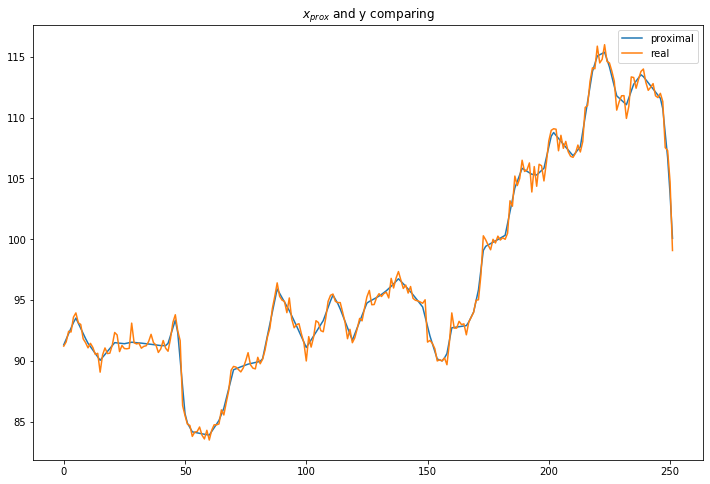

In [251]:
plt.figure(figsize=(12,8))
plt.plot(x_opt_prox, label = 'proximal')
plt.plot(y, label = 'real')
plt.title('$x_{prox}$ and y comparing')
plt.legend()
plt.show()

График, изображающий изменение модуля разности значений функций в двух соседних точках

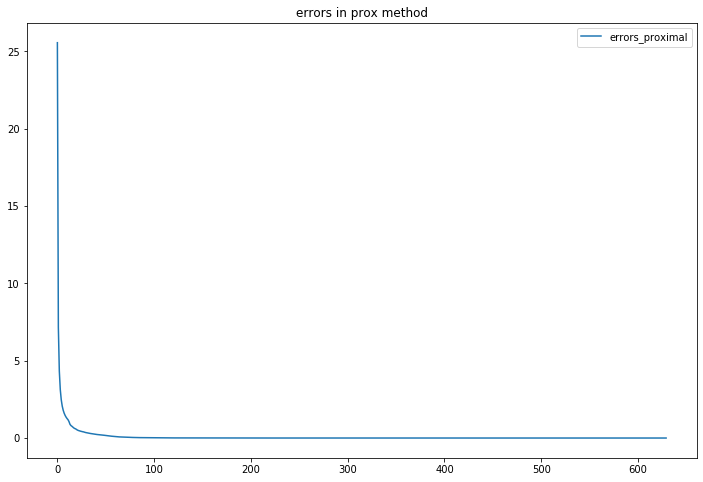

In [252]:
plt.figure(figsize=(12,8))
plt.plot(errors_prox, label = 'errors_proximal')
plt.title('errors in prox method')
plt.legend()
plt.show()

$$------------------------------------------------------------------------------------------------------------------------------$$

# Fast gradient descent with smoothing technique

Пусть $f_{\mu} = \frac{1}{2}||y-x||_2^2 + \lambda||Dx||_1 - \frac{\mu}{2}||u||_2^2$. Эту функцию можно переписать в виде 

$$f_{\mu} = \frac{1}{2}||y-x||_2^2+\max\limits_{-1\leq u_i \leq 1}\left[\sum\limits_{i=1}^n\lambda (u_i(Dx)_i - \frac{\mu}{2}u_i^2\right].$$

Запишем $L_i = \frac{\mu}{2}u_i^2 - \lambda u_i(Dx)_i + a_i(-1-u_i)+b_i(u_i-1)$. Отсюда получаем, что $L_i' = \mu u_i -\lambda (Dx)_i - a_i + b_i = 0$. Отсюда можем выразить $u_i$:

$$u_i = \frac{a_i-b_i+\lambda(Dx)_i}{\mu},$$

при условии, что $a_i(u_i+1) = 0, b_i(u_i-1) = 0$. Также у нас есть ограничение, что $-1\leq u_i \leq 1$. Тогда получаем, что если $-1<u_i <1$, то $a_i=b_i=0$ и $u_i=\frac{\lambda(Dx)_i}{\mu}$, если при этом $ -\mu < \lambda(Dx)_i < \mu$. Если же $-\mu \geq \lambda(Dx)_i$, то $u_i = -1$ и если $\mu \leq \lambda(Dx)_i$, то $u_i = 1$. Таким образом, получаем, что

$$u_i = \begin{cases}-1, \qquad \lambda(Dx)_i \leq -\mu\\
1, \qquad \lambda(Dx)_i  \geq \mu\\
\frac{\lambda(Dx)_i}{\mu}, \qquad -\mu < \lambda(Dx)_i <\mu\end{cases}.\qquad\qquad\qquad(1)$$


Таким образом, при любом $x$ мы можем найти оптимальное $u_{opt}$, по которому восстанавливаем $f_{\mu}$. При этом получаем, что $$f_{\mu} = \frac{1}{2}||y-x||_2^2 + \lambda<u_{opt}, Dx> - \frac{\mu||u_{opt}||_2^2}{2}.$$

Тогда градиент равен

$$\nabla f_{\mu}(x) = x - y + \lambda D^Tu_{opt}.$$

Из лекций ШАДа используем теорему, что если $f_{\mu}(x) = \max\limits_u\left[x^TAu - \varphi(u)-\mu d_2(u)\right]$, то функция имеет липшецев градиент с константой $$L_{\mu} = \frac{1}{\mu \sigma_2}||A||_{1,2}^2,$$ где $d_2(u) \geq \frac{\sigma_2}{2}||u||_2^2$. 

В нашем случае $\sigma_2 = 1$, $||\lambda D||^2_{1,2} = \max{\lambda(DD^T)} \Rightarrow L_{\mu} = \frac{\lambda}{\mu}\max{\lambda(DD^T)} + 1$

(единица добавляется от квадрата второй нормы разности).




Шаги быстрого градиентного спуска:
$$1. Compute f_{\mu}(x_k)~and~\nabla f_{\mu}(x_k).$$

В нашем случае $f_{\mu}(x_k) = \frac{1}{2}||y-x_k||_2^2 + \lambda<u_{opt}, Dx_k> - \frac{\mu||u_{opt}||_2^2}{2}, \nabla f_{\mu}(x_k) = x_k - y + \lambda D^Tu_{opt}.$

$$2. Find~z_k = T_Q(x_k) = argmin_{z}\left[\nabla^T f_{\mu}(x_k)(z-x_k)+\frac{L}{2}||z-x_k||_2^2\right].$$

В нашем случае надо найти $argmin_{z}\left[(x_k - y + \lambda D^Tu_{opt})^T(z-x_k)+\frac{2}{\mu}||z-x_k||_2^2\right]$. Приравняем градиент выражение нулю, откуда найдем $z$:

$$x_k - y + \lambda D^Tu_{opt} + L(z-x_k) = 0 \Rightarrow z_k = -\frac{1}{L}(x_k-y+\lambda D^Tu_{opt}) + x_k$$

$$3. Find~r_k = argmin_r\left[\frac{L}{\sigma_2}d(r) +  \sum\limits_{i=0}^k\alpha_i\left(f(x_i) + \nabla^Tf(x_i)(r-x_i)\right)\right].$$

В нашем случае это будет 

$$r_k = argmin_r \left[\frac{L}{2}||r||_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}(f(x_i) + \nabla^Tf(x_i)(r-x_i))\right].$$

Приравняем градиент по $r$ к нулю и найдем оптимальное $r$:

$$Lr + \sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(x_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=0}^k \frac{i+1}{2}\nabla f(x_i).$$

$$4. Set~x_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$$

In [217]:
def opt_u(x_k):#функция, вычисляющая u_opt
    a = D.dot(x_k)
    b = np.zeros(n - 2)
    for i in range(n-2):
        if (lmb*a[i] < mu and lmb*a[i] > -mu):
            b[i] = lmb*a[i]/mu
        elif (lmb*a[i] >= mu):
            b[i] = 1
        else:
            b[i] = -1
    return b

def f_mu(x_k, u): #функция вычисления f_mu
    a_k = D.dot(x_k)
    return (np.linalg.norm(x_k - y))**2/2.0 + lmb * (u.T.dot(a_k)) - mu/2.0*np.linalg.norm(u)**2

def grad_f(x_k, u): #функция вычисления gradient(f)
    return x_k - y + lmb*D.T.dot(u)

def opt_z(x_k, u): #функция, вычисляющая z_k
    return -1.0/L*(grad_f(x_k, u))+x_k

def opt_r(k, x_k, u): #функция, вычисляющая r_k
    sum = 0
    for i in range(k + 1):
        sum += (i+1)/2.0*(mas_grad_f[i])
    return -1.0/L*sum

def next_x(k, r_k, z_k):
    return 2.0/(k + 3)*r_k+float((k+1))/(k+3)*z_k

In [218]:
mas_f = [] # массив f(x_i)
mas_grad_f = [] #массив gradient(f(x_i))
x0_smooth = np.zeros(n) #начальные точки
#x1_smooth = np.ones(n)
mu = 0.01
#u0_smooth = opt_u(x0_smooth)
#u1_smooth = opt_u(x1_smooth)
lmb = 1
L = lmb*max(np.linalg.eigvals(D.dot(D.transpose())))/mu + 1

In [219]:
mas_f.append(f_mu(x0_smooth, u0_smooth))
mas_f.append(f_mu(x1_smooth, u1_smooth))
mas_grad_f.append(grad_f(x0_smooth, u0_smooth))
mas_grad_f.append(grad_f(x1_smooth, u1_smooth))

In [ ]:
errors_smooth = [] #массив, в котором будем хранить невязку
mas_f = []# массив, в котором будем хранить значения функций
mas_grad_f = [] #массив gradient(f(x_i))
x_smooth = np.zeros(n)#инициализация
z_opt = np.zeros(n)
r_opt = np.zeros(n)
k = 0
u_smooth = opt_u(x_smooth)
mas_f.append(f_mu(x_smooth, u_smooth))
mas_grad_f.append(grad_f(x_smooth, u_smooth))
er = 1
while er > 0.001:
    gradient = mas_grad_f[k]
    z_opt = x_smooth - gradient/L
    r_opt = r_opt - float((k+1))*gradient/(2*L)
    x_smooth = 2*r_opt/(i+3) + (i+1)*z_opt/(i+3)
    u_smooth = opt_u(x_smooth)
    k+=1
    mas_f.append(f_mu(x_smooth, u_smooth))
    mas_grad_f.append(grad_f(x_smooth, u_smooth))
    er = abs(mas_f[k] - mas_f[k-1])
    errors_smooth.append(er)
    print (er)
    print (x_smooth[0], x_smooth[1])

In [224]:
opt_smooth = 1.0/2*np.linalg.norm(y-x_smooth)**2 + np.linalg.norm(D.dot(x_smooth), ord=1)
print (opt_smooth, x_smooth[0:3])

71.22671368568572 [91.32067745819323 91.78657573088539 92.24920890187218]


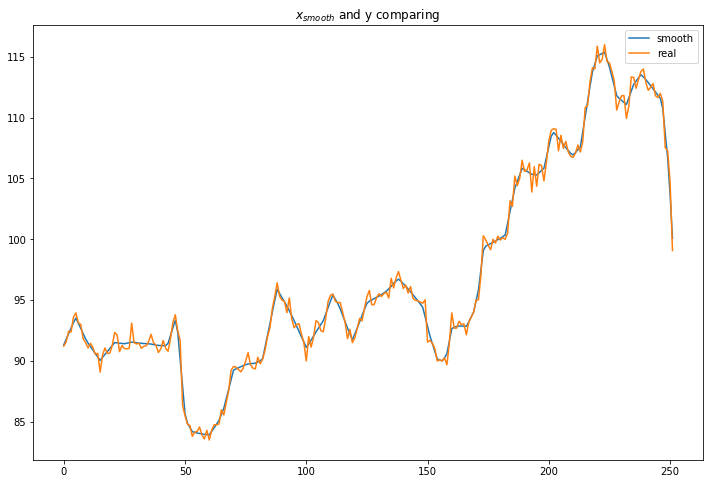

In [225]:
plt.figure(figsize=(12,8))
plt.plot(x_smooth, label = 'smooth')
plt.plot(y, label = 'real')
plt.title('$x_{smooth}$ and y comparing')
plt.legend()
plt.show()

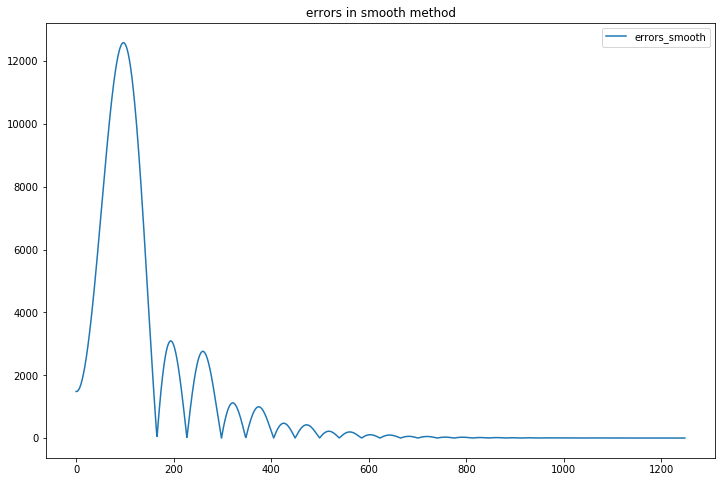

In [226]:
plt.figure(figsize=(12,8))
plt.plot(errors_smooth, label = 'errors_smooth')
plt.title('errors in smooth method')
plt.legend()
plt.show()

$$------------------------------------------------------------------------------------------------------------------------------$$

# ADMM

3. Выпишем схему для метода ADMM. От исходной задачи перейдем к эквивалентной задаче $$\begin{cases}\min\limits_{x,z}~\frac{1}{2}||y-x||^2_2 + \lambda||z||_1\\
subject~to~z = Dx\end{cases}$$
Построим модификацию функции Лагранжа $$L_r = \frac{1}{2}||y-x||_2^2+\lambda ||z||_1 + \frac{1}{2r}||\mu+r(Dx-z)||_2^2-\frac{||\mu||_2^2}{2r}.$$
Общая схема метода ADMM:
$$\begin{cases}x^{k+1} = argmin~L_r(x,z^k,\mu^k)\\
z^{k+1} = argmin~L_r(x^{k+1}, z, \mu^k)\\
\mu^{k+1} = \mu^k + r(Dx^{k+1} - z^{k+1})\end{cases}$$

Условие оптимальности по $x$:
$$\nabla_xL_r = 0 = x - y + D^T(\mu + r(Dx-z)) \Rightarrow x = (I + rD^TD)^{-1}(y+rD^Tz-D^T\mu)$$
Отсюда получаем, что $$x^{k+1} = (I + rD^TD)^{-1}(y + rD^Tz^k -D^T\mu^k)$$
Условие оптимальности по $z$:
$$\lambda \partial||z||_1 - (\mu + r(Dx - z)) = 0$$
Перейдем к координатной записи
$$\lambda \begin{cases} 1, z_i > 0 \\
-1, z_i < 0 \\
[-1,1], z_i = 0
\end{cases} - \mu_i -r(Dx)_i + rz_i = 0 \Rightarrow z_i = \frac{1}{r}\begin{cases}\mu_i +r(Dx)_i - \lambda, \qquad if~(\mu_i + r(Dx)_i) > \lambda\\
\mu_i +r(Dx)_i + \lambda,\qquad if~(\mu_i + r(Dx)_i) < -\lambda\\
0, \qquad if~(\mu_i + r(Dx)_i) \in [-\lambda, \lambda]\end{cases}$$
Отсюда можем определить формулу преобразования для $z$:
$$z^{k+1}_i = \frac{1}{r}\begin{cases}\mu_i^k +r(Dx^{k+1})_i - \lambda, \qquad if~(\mu_i^k + r(Dx^{k+1})_i) > \lambda\\
\mu_i^k +r(Dx^{k+1})_i + \lambda,\qquad if~(\mu_i^k + r(Dx^{k+1})_i) < -\lambda\\
0, \qquad if~(\mu_i^k + r(Dx^{k+1})_i) \in [-\lambda, \lambda]\end{cases}$$
Для параметра $\mu$ преобразование известно:
$$\mu^{k+1} = \mu^k + r(Dx^{k+1} - z^{k+1}).$$
Далее идет численная реализация данного метода

In [229]:
r=100#задали параметры система
l = 1 

x0_admm = np.zeros(n)#инициализация x
x1_admm = np.ones(n)
#x1 = x_opt
mu0_admm = np.zeros(n - 2) #инициализация mu
mu1_admm = np.ones(n - 2)
z0_admm = np.zeros(n - 2) #инициализация z
z1_admm = np.ones(n - 2)

A = D.T.dot(D) #матрица D^TD
B = np.linalg.inv(r*A + np.eye(n)) #матрица (D^TD + I)^(-1)

In [230]:
def L_r(x, mu, z): #функция для вычисления L_r
    a = 1.0/2*np.linalg.norm(y-x)**2 + l*np.linalg.norm(z, ord=1)
    b = mu + r*(D.dot(x) - z)
    c = 1.0/2/r*np.linalg.norm(b)**2 - 1.0/2/r*np.linalg.norm(mu)**2
    return c

def x_new(mu_old, z_old): #функция преобразования x
    a = y + r*D.T.dot(z_old) - D.T.dot(mu_old)
    return B.dot(a)

def mu_new(x_old, mu_old, z_old): #функция преобразования mu
    return mu_old + r*(D.dot(x_old) - z_old)

def z_new(x_old, mu_old): #функция преобразования z
    a = mu_old + r*(D.dot(x_old))
    ans = np.zeros(n - 2)
    for i in range(0, n - 2):
        if (a[i] > l):
            ans[i] = (a[i] - l)/r
        elif (a[i] < -l):
            ans[i] = (a[i] + l)/r
        else:
            ans[i] = 0
    return ans

In [ ]:
a0 = L_r(x0_admm, mu0_admm, z0_admm)
a1 = L_r(x1_admm, mu1_admm, z1_admm)
errors_admm = []
eps1 = math.fabs(a0 - a1)
errors_admm.append(eps1)
#eps = np.linalg.norm(x1-x_opt)
print (eps1)
while eps1 > 10**(-6):
    x0_admm = x1_admm
    x1_admm = x_new(mu1_admm, z1_admm)
    z0_admm = z1_admm
    z1_admm = z_new(x1_admm, mu1_admm)
    mu0_admm = mu1_admm
    mu1_admm = mu_new(x1_admm, mu0_admm, z1_admm)
    a0 = a1
    a1 = L_r(x1_admm, mu1_admm, z1_admm)
    eps1 = math.fabs(a0 - a1)
    errors_admm.append(eps1)
    #eps = np.linalg.norm(x1 - x_opt)
    print (eps1)

In [239]:
opt1 = 1.0/2*np.linalg.norm(y-x1_admm)**2 + np.linalg.norm(D.dot(x1_admm), ord=1)
err1 = np.linalg.norm(x1_admm - x_opt_prox)
err2 = np.linalg.norm(x1_admm - x1_smooth)
print (opt1, err1, err2)


70.70366545367446 0.7998171916887252 1528.2511110161145


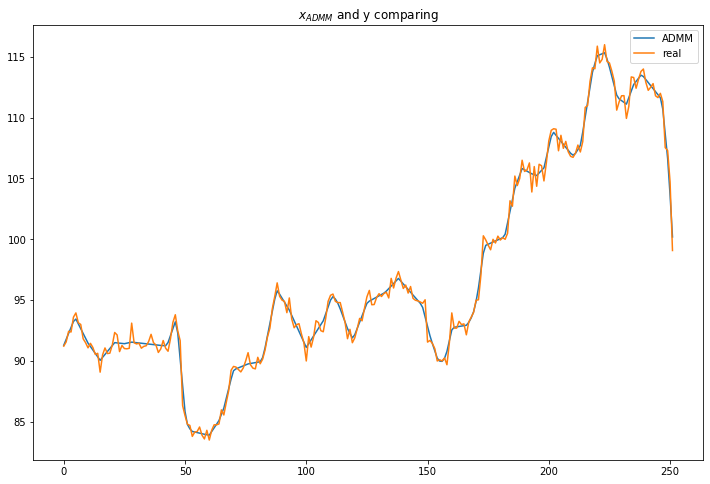

In [240]:
plt.figure(figsize=(12,8))
plt.plot(x1_admm, label = 'ADMM')
plt.plot(y, label = 'real')
plt.title('$x_{ADMM}$ and y comparing')
plt.legend()
plt.show()

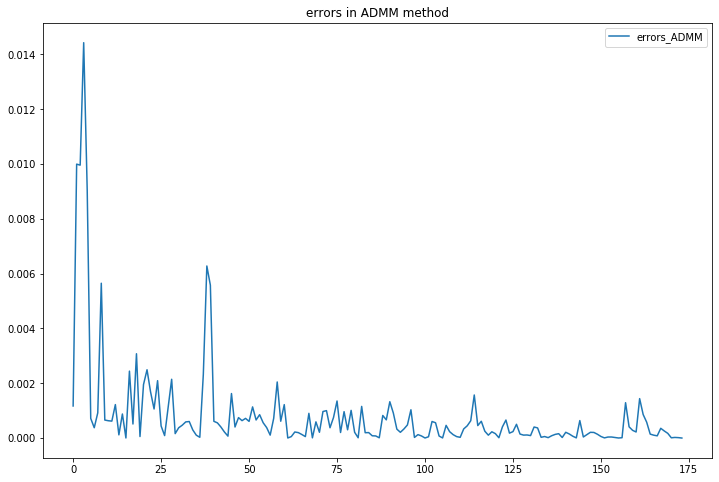

In [242]:
plt.figure(figsize=(12,8))
plt.plot(errors_admm[1:], label = 'errors_ADMM')
plt.title('errors in ADMM method')
plt.legend()
plt.show()

In [235]:
print(np.linalg.norm(x1_admm - y), np.linalg.norm(x_smooth - y), np.linalg.norm(y - x_opt_prox))

9.707394058683239 8.35880376570729 8.391722612622912


# ADMM (13 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

# RegMC problem

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (1 pts) Сведите задачу RegMC к виду, пригодному для решения алгоритмом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.
3. (2 pts) Реализуйте метод ADMM. 
4. (5 pts) Протестируйте алгоритм из п.3 на тестовых данных. Сравните полученные результаты с результатами алгоритмов из ДЗ4.
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





Построим эквивалентную задачу
$$
\begin{cases}
\min_X~ ||X||_* + I_Q(Z)
\\
subject~to~X = Z
\end{cases}
$$

Здесь введена индикаторная функция множества $E$:
$$
I_E(Z) = \begin{cases}
0,if~\forall~(i,j)\in E \rightarrow Z_{i,j} = Y_{i,j}\\
+\infty, ~in~other~cases
\end{cases}
$$

Уже в таком виде задачу можно решать при помощи ADMM. Для этого запишем измененный лагранжиан

$$
L(X, Z, U) = ||X||_* + I_E(Z) + \frac{1}{2r}||U + r(X - Z)||_F^2 - \frac{||U||_F^2}{2r}.
$$

Тогда преобразования запишутся следующим образом

$$
\begin{cases}
&X^{k+1} = argmin_{X}\left(||X||_* + \dfrac{1}{2r}||r(X - Z^{k}) + U^k||_F^2\right)
\\
&Z^{k+1} = \pi_E\left(X^{k+1} + \frac{1}{r}U^k\right)
\\
&U^{k+1} = U^k + r(X^{k+1} - Z^{k+1}).
\end{cases}
$$

Нужно уметь решать задачу $argmin_{X}\left(||X||_* + \frac{1}{2r}||r(X - Z^{k}) + U^k||_F^2\right)$. Для этого используем сингулярное разложение. Заметим, что все сингулярные числа неотрицательны, поэтому вектор, составленный из сингулярных чисел, будет иметь первую норму, равную норме Шаттена исходной матрицы. Используем это, а также тот факт, что фробениусовская норма матрицы в квадрате есть сумма квадратов сингулярных чисел, то есть вторая норма в квадрате вектора, составленного из сингулярных чисел. Введем вектор $s(A)$ - вектор, составленный из сингулярных чисел матрицы $A$. Обозначим $x = s(X), z = s(Z), u = s(U)$, тогда получим задачу уже на вектора:

$$
argmin_{x}(||x||_{1} + \frac{1}{2r}||r(x - z) + u||_2^2)
$$
Здесь мы считаем, что все матрицы имеют одни и те же $W$ и $V$ в сингулярном разложении. Видно, что задача сепарабельная. Получаем для $i$-ой компоненты задачу

$$
argmin_{x_i}(|x_i| + \frac{1}{2r}|r(x_i - z_i) + u_i|^2)
$$

$$
x_i = \begin{cases}
\frac{rz_i - u_i - 1}{r},~if~ \frac{rz_i - u_i}{r} > \frac{1}{r}\\
\frac{rz_i - u_i + 1}{r},~if~ \frac{rz_i - u_i}{r} < \frac{-1}{r}\\
0,~if~ \frac{rz_i - u_i}{r} \in \left[\frac{-1}{r}, \frac{1}{r}\right]
\end{cases}.
$$
На самом деле второй случай можно убрать, так как сингулярное число должно быть неотрицательным.

Найдя новый $x$, можем найти и саму матрицу $X$: $X^{k+1} = W\Sigma V^T$, где $\Sigma_{i,i} = x_i, \Sigma_{i,j} = 0,~if~i \neq j$.

Для нахождения $Z^{k+1}$ нужно взять проекцию на множество. В данном случае это будет выглядеть так:
$$
Z_{i,j}^{k+1} = \begin{cases}Y_{i,j},~ \forall (i,j) \in E\\
(X^{k+1} + \frac{1}{r}U^k)_{i,j}, ~in~other~cases
\end{cases}
$$

In [83]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [122]:
n = 5
m = 8

In [123]:
np.random.seed(0)
Y = 10*np.random.rand(n,m)
E = [[1,2], [2,3], [2,2], [4,5], [0,0]]

In [124]:
def opt_x(Z, U):
    W, S, V = np.linalg.svd(r*Z - U, full_matrices=True)
    x = np.zeros(len(S))
    for i in range(len(S)):
        if (S[i] > 1):
            x[i]=(S[i] - 1)/r
        else:
            x[i] = 0
    P = np.zeros((n,m))
    for i in range(len(S)):
        P[i][i] = x[i]
    #print(P)
    return W.dot(P).dot(V)

def proector(A):
    for pare in E:
        A[pare[0]][pare[1]] = Y[pare[0]][pare[1]]
    return A

def opt_z(X, U):
    Z = X+(1/r)*U
    Z = proector(Z)
    return Z

def L_r(X, U, Z):
    a = np.linalg.norm(X, ord='nuc')
    b = (1/(2*r))*(np.linalg.norm(r*(X-Z) + U))**2
    c = (1/(2*r))*(np.linalg.norm(U))**2
    return a + b - c

In [125]:
np.random.seed(0)
X = np.random.rand(n,m)
Z = np.random.rand(n,m)
U = np.random.rand(n,m)
r = 1000

In [ ]:
for i in range(100000):
    W, S, V = np.linalg.svd(X, full_matrices=True)
    X = opt_x(Z, U)
    Z = opt_z(X, U)
    U = U + r*(X - Z)
    print (L_r(X, U, Z))

In [127]:
print(E)

[[1, 2], [2, 3], [2, 2], [4, 5], [0, 0]]


In [132]:
print (Z)
print (Z- Y)

[[5.48813504e+00 5.52066036e-05 5.82098743e-01 3.78130363e-01
  8.69209917e-05 8.42039686e-01 8.20372126e-05 2.72721050e-05]
 [5.81777100e-01 5.67168738e-04 7.91725038e+00 7.76254742e+00
  8.93951492e-04 4.40325187e-01 8.44220661e-04 2.80527016e-04]
 [3.79185902e-01 5.95516150e-04 7.78156751e+00 8.70012148e+00
  9.38643087e-04 1.26627779e-01 8.86431847e-04 2.94551987e-04]
 [9.08458264e-05 6.93752692e-08 9.34817697e-04 9.79225428e-04
  1.09346479e-07 6.15477996e-05 1.03263296e-07 3.43135239e-08]
 [8.42022821e-01 3.74284156e-05 4.40241064e-01 1.25675729e-01
  5.88493064e-05 6.16933997e+00 5.55026578e-05 1.84610504e-05]]
[[ 0.         -7.15183846 -5.44553502 -5.07070147 -4.23646107 -5.61690144
  -4.37579008 -8.91770274]
 [-9.0548505  -3.83384802  0.          2.47359822 -5.67955166 -8.8156412
  -0.70951636 -0.87101247]
 [ 0.17700193 -8.32560294  0.          0.         -9.78524478 -7.86495786
  -4.61390719 -7.80499721]
 [-1.18265341 -6.39921014 -1.43259806 -9.44570995 -5.21848311 -4.1465578

In [130]:
#сравнение ответа, который находится в Z, с матрицей, у которой все элементы нулевые за исключением тех, которые лежат в E
Q = np.zeros((n,m))
Q = proector(Q)
print (np.linalg.norm(Q - Z))

7.940955675595269
